In [1]:
# init
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import math
import random

import warnings
#warnings.filterwarnings("ignore")

def distance(x,y):
    
    z = x - y
    z **= 2
    return math.sqrt(z.sum())

In [2]:
# valuable constants

# testing part, probably removable
#np.random.seed(10)
#random.seed(100)

# size of area, from -x to x
area_size = 14

# amount of attractors and distractors
att_am = 8
dis_am = att_am * 2

# minimal distance from attractor to attractor and from distractor to attractor
dist_att = int ((2 * area_size + 1)/ (math.sqrt(att_am))) - 1
dist_dis = int(dist_att / 2)

# amount of points, amount of numbers after . (.0 rn)
points_am = 400
prec = 1
#print (dist_att, dist_dis)

In [3]:
# generating attraction and distraction points with the rules:
# attraction points have to be far enought from each other
# distraction points have to be far enought from each other\attraction points

attract = np.empty(2).reshape(-1, 2)

flag = True
att_iter = 0

while att_iter < att_am:
    
    we_add = np.round(2 * area_size * (0.5 - np.random.rand(2)), 
                      prec).reshape(-1, 2)
    
    if flag:
        
        attract = we_add
        flag = False
        att_iter += 1
        
    else:
        
        closest_att = distance(attract[0],we_add)
        
        for i in range(att_iter):
            
            a = distance(attract[i],we_add)
            
            if a < closest_att:
                
                closest_att = a
            
        if closest_att > dist_att:
            
            attract = np.concatenate([attract, we_add])
            att_iter += 1


distract = np.empty(2).reshape(-1, 2)

flag = True
dis_iter = 0

while dis_iter < dis_am:                
    
    we_add = np.round(2 * area_size * (0.5 - np.random.rand(2)), 
                      prec).reshape(-1, 2)
    
        
    closest_att = distance(attract[0], we_add)

    for i in range(att_iter):

        a = distance(attract[i], we_add)

        if a < closest_att:

            closest_att = a
            
    if flag:
        
        closest_dis = 2 * dist_dis
        
    else:
        
        closest_dis = distance(distract[0], we_add)
        
        for i in range(dis_iter):
            
            a = distance(distract[i], we_add)
            
            if a < closest_dis:
                
                closest_dis = a

    if closest_dis > dist_dis and closest_att > dist_dis:

        if flag:
            
            distract = we_add
            flag = False
            dis_iter += 1
        
        else:
            distract = np.concatenate([distract, we_add])
            dis_iter += 1

In [4]:
# generating points with the interpolary rule : random(0,1) < chance
# chance is (b/(a+b))^3
# b - distance to closest distractor, a - distance to closest attractor

points = np.empty(2).reshape(-1, 2)

flag = True
iterator = points_am

while iterator > 0:
    
    we_add = np.round(2 * area_size * (0.5 - np.random.rand(2)),
                      prec).reshape(-1,2)
    
    closest_att = distance(attract[0], we_add)
    for i in range(att_am):
        
        a = distance(attract[i], we_add)
        
        if a < closest_att:
            
            closest_att = a
        
    closest_dis = distance(distract[0], we_add)
    for i in range(dis_am):
        
        a = distance(distract[i], we_add)
        
        if a < closest_dis:
            
            closest_dis = a
            
    chance = (closest_dis / (closest_dis + closest_att)) ** 4
    
    if chance > random.random() and closest_att < closest_dis:
        
        if flag:
            
            points = we_add
            flag = False
        
        else:
            
            points = np.concatenate([points, we_add])
            
            
        iterator -= 1

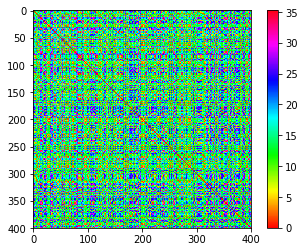

In [5]:
# generating and visualising range matrix (symmetric)
# points - all points we have

a = points.T

x = (a[0] - a[0].reshape(-1, 1)) ** 2
y = (a[1] - a[1].reshape(-1, 1)) ** 2

len = np.sqrt(x + y)

plt.imshow(len, cmap = 'hsv')
plt.colorbar(orientation = 'vertical', pad = 0.05)

In [6]:
# global k-means function
# initialising cluster centers by k-means ++ methodic
# showing only final result

# also uses some external data - array "points", "area_size" and "points_am"

def k_means(clusters_am, points_am, points):
    
    we_not_finished = True
    keep = 0 + clusters_am
    
    while we_not_finished:
    
        cluster_centers = np.zeros(2 * clusters_am).reshape(-1, 2)
        points_associations = np.zeros(points_am, dtype = 'int') - 1

        for i in range(clusters_am):

            if i == 0:

                cluster_centers[0] = points[0]

            else:

                if i == 1:

                    range_map = (points.T[0] - 
                                 cluster_centers.T[0][i-1].reshape(-1, 1)) ** 2 + (points.T[1] - 
                                                                                  cluster_centers.T[1][i - 1].reshape(-1, 1)) ** 2

                else:
                    map_part = (points.T[0] - 
                                cluster_centers.T[0][i-1].reshape(-1, 1)) ** 2 + (points.T[1] - 
                                                                                  cluster_centers.T[1][i - 1].reshape(-1, 1)) ** 2

                    range_map = np.concatenate([range_map,map_part])

                dist = np.min(range_map, axis = 0)

                sum = np.sum(dist)
                rnd = random.uniform(0.01, 0.99) * sum

                sum1 = 0
                chos = -1

                while sum1 < rnd:

                    sum1 += dist[chos]
                    chos += 1

                cluster_centers[i] = points[chos]


        outer_flag = True

        while outer_flag:

            for i in range(points_am):

                ranges = np.sqrt((points[i][0] - 
                                  cluster_centers.T[0].reshape(-1, 1)) ** 2 + (points[i][1] - 
                                                                               cluster_centers.T[1].reshape(-1, 1)) ** 2)

                points_associations[i] = np.argmin(ranges[:clusters_am])
                

            new_centers = np.zeros(2 * clusters_am).reshape(-1, 2)
            new_count = np.zeros(clusters_am, dtype = 'int')

            for number, point in enumerate(points):

                #print(number, point, points_associations[number])
                new_centers[points_associations[number]] += point
                new_count[points_associations[number]] += 1

                
            if 0 in new_count:
                
                break;
                
            for j in range(clusters_am):
                
                new_centers[j] /= new_count[j]

            new_centers = np.round(new_centers, 1)
            new_flag = True

            for j in range(clusters_am):

                if not np.array_equal(cluster_centers[j], new_centers[j]):

                    cluster_centers[j] = new_centers[j]
                    new_flag = False


            outer_flag = not new_flag

            
        if outer_flag == False:
            
            we_not_finished = False
        
    return cluster_centers, points_associations

In [7]:
def avg_range(clusters_am, cluster_centers, points, points_associations):
    
    sum_dist = np.zeros(clusters_am)
    am_ele = np.zeros(clusters_am, dtype = 'int')
    
    for i, point in enumerate(points):
        
        sum_dist[points_associations[i]] += distance(point, cluster_centers[points_associations[i]])
        am_ele[points_associations[i]] += 1
    
    return sum_dist / am_ele

def mk_rangemap(given_points):
    """building square - like matrix of distance between points from input
       returning matrix, getting in only points"""
    
    a = given_points.T

    x = (a[0] - a[0].reshape(-1, 1)) ** 2
    y = (a[1] - a[1].reshape(-1, 1)) ** 2

    return np.sqrt(x + y)

def mk_rangeline(given_point, array):
    """building line of distance from point to others given in array, form - factor of array - (-1, 2)
       returning line, getting in point + points to compare distances"""
    
    a = array.T
    
    x = (given_point[0] - a[0].reshape(-1, 1)) ** 2
    y = (given_point[1] - a[1].reshape(-1, 1)) ** 2
    
    return np.sqrt(x + y)

def mk_rangeduo(f_points, s_points):
    """rangemap of 2 groups of elements"""
    a = f_points.T
    b = s_points.T
    
    x = (a[0] - b[0].reshape(-1, 1)) ** 2
    y = (a[1] - b[1].reshape(-1, 1)) ** 2
    
    return np.sqrt(x + y)

In [8]:
# getting amount of dots in each cluster

def amount_in_each(clusters_am, points_associations):
    
    ret = np.zeros(clusters_am, dtype = 'int')
    
    for i in points_associations:
        
        ret[i] +=1
        
    return ret

In [9]:
# separating all given points into list consisting np.array of dots in each uniq class

def separate(clusters_am, points, points_associations):
    
    am_each = amount_in_each(clusters_am, points_associations)
    
    list_of_points = []

    for i in range(clusters_am):
        
        list_of_points.append(np.empty(2 * am_each[i]).reshape(-1, 2))
        
    used_rn = np.zeros(clusters_am, dtype = 'int')
    
    for i, point in enumerate(points):
        
        part = points_associations[i]
        
        list_of_points[part][used_rn[part]] = point
        
        used_rn[part] += 1
        
    return list_of_points

In [10]:
# checking group of points if they are separated into any lesser groups

def check(in_points, am_points, crit_range):
    """returns True if all the area is one big cluster, False otherwise"""
    
    we_used = np.zeros(am_points, dtype = 'int') - 1
    we_used[0] = 0
    
    rangemap = mk_rangemap(in_points)
    
    flag = True
    
    while flag:
        
        inner_flag = True
        
        for i in np.argwhere(we_used == 0):
            num = np.int(i)
            #print(num)
            
            for j in np.argwhere(rangemap[num] < crit_range):
                
                if we_used[j] != 0:
                    we_used[j] = 0
                    inner_flag = False
                    
        flag = not inner_flag
        
    #print(we_used)
    #print(np.unique(we_used))
        
    if -1 in np.unique(we_used):
        return False   # means we have it separated
    else:
        return True    # means we don't have it separate

In [11]:
# generating center of group of points

def mk_center(in_points):
    
    am_p = in_points.shape[0]

    return np.sum(in_points, axis = 0) / am_p

In [12]:
# now we try to unite clusters we separateds

def unite_this_2(f_clust, s_clust):
    """checking if we have to unite 2 sent to clusters"""
    
    requied_dist = 1
    requied_am = 3
    
    rng_map = mk_rangeduo(f_clust, s_clust)
    
    for curr in rng_map:
        
        if np.min(curr) < requied_dist:
            requied_am -= 1
            
    
    
    if requied_am <= 0:
        
        return True
    
    else:
        
        return False    

Finished points generation


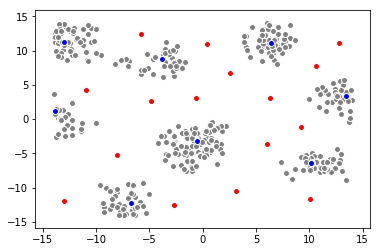

Finished initialising clusterisation


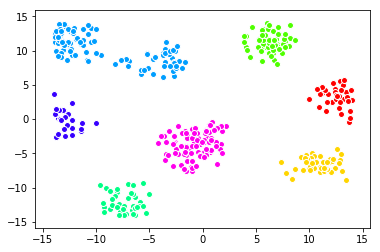

Finished clusters amount reduction


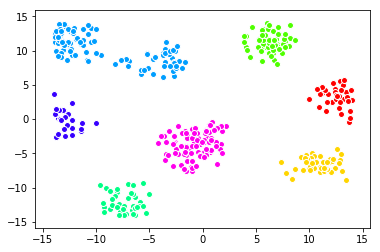

In [14]:
print('Finished points generation')

fig = plt.figure()


for i in range(points_am):
    
    plt.scatter(points[i][0],
                points[i][1], 
                color = 'gray', 
                edgecolors = 'white')
    

for i in range(att_am):
    
    plt.scatter(attract[i][0],
                attract[i][1], 
                color = 'blue', 
                edgecolors = 'white')
    
for i in range(dis_am):
    
    plt.scatter(distract[i][0],
                distract[i][1], 
                color = 'red', 
                edgecolors = 'white')
    
plt.show()


cl_flag = True

clusters_am = 0

while cl_flag:
    
    clusters_am += 1
    
    cl_centers, p_associations = k_means(clusters_am, points_am, points)
    
    amo_each = amount_in_each(clusters_am, p_associations)
    
    cl_list = separate(clusters_am, points, p_associations)
    
    exit_no = True
    
    for i in range(clusters_am):
        
        exit_no = exit_no & check(cl_list[i], amo_each[i], 4)
        
    cl_flag = not exit_no
    
print('Finished initialising clusterisation')

colors = [cm.hsv(i/(clusters_am)) for i in range(clusters_am)]

fig = plt.figure()

for i in range(points_am):
    
    plt.scatter(points[i][0],
                points[i][1],
                color = colors[p_associations[i]],
                edgecolors = 'white')
    
plt.show()

restart = True

while restart:
    
    changed = False

    for i, f_cluster in enumerate(cl_list):

        for j, s_cluster in enumerate(cl_list):

            if i != j:

                if unite_this_2(f_cluster, s_cluster):

                    if i < j:
                        minimal = i
                        maximal = j
                    else:
                        minimal = j
                        maximal = i
                    
                    for k in np.argwhere(p_associations == maximal):

                        p_associations[np.int(k)] = minimal
                        
                    for k in range(points_am):
                        
                        if p_associations[k] > maximal:
                            
                            p_associations[k] -= 1

                    cl_list[minimal] = np.concatenate([cl_list[minimal], cl_list[maximal]])
                    
                    del cl_list[maximal]
                    
                    clusters_am -= 1
                    
                    changed = True
            
            if changed:
                break;
        
        if changed:
            break;
            
    if not changed:
        restart = False
        
print('Finished clusters amount reduction')

outer_flag = True

cluster_centers = np.zeros(2 * clusters_am).reshape(-1, 2)
cluster_count = np.zeros(clusters_am, dtype = 'int')

for number, point in enumerate(points):

    cluster_centers[p_associations[number]] += point
    cluster_count[p_associations[number]] += 1

for i in range(clusters_am):
    
    cluster_centers[i] /= cluster_count[i]

while outer_flag:

    for i in range(points_am):

        ranges = np.sqrt((points[i][0] - 
                          cluster_centers.T[0].reshape(-1, 1)) ** 2 + (points[i][1] - 
                                                                       cluster_centers.T[1].reshape(-1, 1)) ** 2)

        p_associations[i] = np.argmin(ranges[:clusters_am])


    new_centers = np.zeros(2 * clusters_am).reshape(-1, 2)
    new_count = np.zeros(clusters_am, dtype = 'int')

    for number, point in enumerate(points):
        
        new_centers[p_associations[number]] += point
        new_count[p_associations[number]] += 1

        
    for j in range(clusters_am):

        new_centers[j] /= new_count[j]

    new_centers = np.round(new_centers, 1)
    new_flag = True

    for j in range(clusters_am):

        if not np.array_equal(cluster_centers[j], new_centers[j]):

            cluster_centers[j] = new_centers[j]
            new_flag = False


    outer_flag = not new_flag

        
colors = [cm.hsv(i/(clusters_am)) for i in range(clusters_am)]

fig = plt.figure()

for i in range(points_am):
    
    plt.scatter(points[i][0],
                points[i][1],
                color = colors[p_associations[i]],
                edgecolors = 'white')
    
plt.show()